In [45]:

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np
from sklearn.utils import resample
import random
# Import necessary libraries
from keras.datasets import cifar10

In [46]:
import datetime
from datetime import datetime

config = {
    'currentModel' : 'ENSEMBLE',
    'training' : True,
    'overFit' : False,
    'heldOutClasses' : True,
    'epochs' : 20,
    'patience' : 10,
    'saveModel' : True,
    'seed': 0,
}

config['ensembleSize'] = 20 if 'ENSEMBLE' in config['currentModel'] else 1
config['startEpochs'] = 20 if 'overFit' in config['currentModel'] else 1

# Formatted as 'YYYY-MM-DD'
today = datetime.today().strftime('%Y-%m-%d')

# Get file representation of the config folder 
file_str = f'/{today}/'

for key, value in config.items():
    file_str += f'{key}-{value}_' 


MODEL_FILE = f'./models/' + file_str

np.random.seed(config['seed'])
# set random seed for tf
tf.random.set_seed(config['seed'])
# random seed for python built-in random module
random.seed(config['seed'])

In [47]:
from sklearn.model_selection import train_test_split

dataset = cifar10.load_data()

# Turn it into a binary classification problem by making it frogs or not frogs
(train_images, train_labels), (test_images, test_labels) = dataset

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Separate frog and not frog images
frog_indices = np.where(train_labels == 6)[0]
not_frog_indices = np.where(train_labels != 6)[0]

if config['heldOutClasses']:
    config['heldOutClasses'] = [0, 1]
else:
    config['heldOutClasses'] = []

held_out_class_indices_train = np.where(np.isin(train_labels, config['heldOutClasses']))[0]    
held_out_class_indices_test = np.where(np.isin(test_labels, config['heldOutClasses']))[0]    

not_frog_indices = np.setdiff1d(not_frog_indices, held_out_class_indices_train)

# Downsample majority (not frog)
not_frog_downsampled = resample(not_frog_indices,
                                replace=False, # sample without replacement
                                n_samples=len(frog_indices), # match minority n
                                random_state=27) # reproducible results

# Combine minority and downsampled majority
downsampled_indices = np.concatenate([frog_indices, not_frog_downsampled])

# Downsampled feature and label sets
train_labels = np.where(train_labels == 6, 1, 0)
test_labels = np.where(test_labels == 6, 1, 0)

train_images = train_images[downsampled_indices]
train_labels = train_labels[downsampled_indices]

test_images_held_out = test_images[held_out_class_indices_test]
test_labels_held_out = test_labels[held_out_class_indices_test]

test_images = np.delete(test_images, held_out_class_indices_test, axis=0)
test_labels = np.delete(test_labels, held_out_class_indices_test, axis=0)


# Split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=config['seed'])




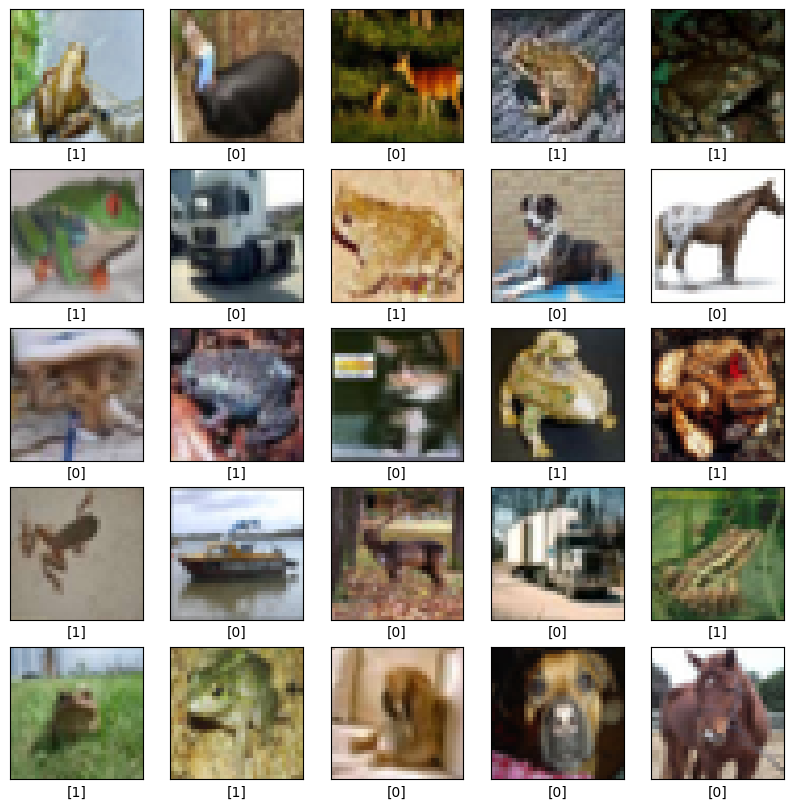

In [48]:
class_names = ['not_frog', 'frog']

randomly_chosen_indexes = np.random.uniform(0, len(train_images), 25).astype(int)
plt.figure(figsize=(10,10))
for i, value in enumerate(randomly_chosen_indexes):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[value])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(train_labels[value])
plt.show()

### Compile and train the model

In [49]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



history_list = {}

history_dict_base = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

history_dict = {}


for i in range(config['ensembleSize']): 
    history_dict[i] = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
    }

    history_list[i] = []

print(history_dict)



{0: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 1: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 2: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 3: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 4: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 5: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 6: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 7: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 8: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 9: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 10: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 11: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 12: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 13: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 14: {'accuracy': [], 'val_acc

In [50]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model

# Function to set dropout rate
def set_dropout_rate(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = new_rate


def create_dropout_model(dropout_rate=0.5):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model
  

In [51]:
 
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model

def create_model():
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [52]:


for i in range(config['ensembleSize']):

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_auc', patience=config['patience'], start_from_epoch=config['startEpochs'], restore_best_weights=True, mode='max')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(f'{MODEL_FILE}/{i}.keras', monitor='val_auc', save_best_only=True)

    callbacks = [early_stopping]

    if config['saveModel']:
        callbacks.append(model_checkpoint)


    model = create_dropout_model() if config['currentModel'] == 'BNN' else create_model()
    
    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')])

    set_dropout_rate(model, np.nextafter(np.float32(0), np.float32(1))) if config['currentModel'] == 'BNN' else ''

    X_train_subset, y_train_subset = resample(train_images, train_labels)

    history = model.fit(X_train_subset, y_train_subset, epochs=config['epochs'],
                        validation_data=(val_images, val_labels),
                        callbacks=[early_stopping, model_checkpoint])

    set_dropout_rate(model, 0.5) if config['currentModel'] == 'BNN' else ''

    history_list[i].append(history)

    for history in history_list[i]:
        for key in history_dict_base.keys():
            history_dict[i][key].extend(history.history[key])


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6488 - auc: 0.7067 - loss: 0.6045 - val_accuracy: 0.7860 - val_auc: 0.8942 - val_loss: 0.4603
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8142 - auc: 0.8937 - loss: 0.4123 - val_accuracy: 0.8505 - val_auc: 0.9244 - val_loss: 0.3618
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8463 - auc: 0.9244 - loss: 0.3503 - val_accuracy: 0.8590 - val_auc: 0.9301 - val_loss: 0.3510
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8691 - auc: 0.9423 - loss: 0.3065 - val_accuracy: 0.8705 - val_auc: 0.9379 - val_loss: 0.3375
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8880 - auc: 0.9578 - loss: 0.2627 - val_accuracy: 0.8745 - val_auc: 0.9418 - val_loss: 0.3376
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9013 - auc: 0.9658 - loss: 0.2364 - val_accuracy: 0.8665 - val_auc: 0.9405 - val_loss: 0.3636
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━

In [53]:
if config['currentModel'] == 'BNN':
    import numpy as np
    from tensorflow.keras.models import load_model

    class MCDropoutModel:
        def __init__(self, base_model, num_predictions=100, dropout_rate=0.5):
            self.base_model = base_model
            self.num_predictions = num_predictions
            self.dropout_rate = dropout_rate

        def verbose_predict(self, inputs):
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                outputs.append(self.base_model(inputs, training=True))

            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack

    loaded_model = load_model(f'{MODEL_FILE}/0.keras')

    # Wrap the base model with the MCDropoutModel
    model_under_test = MCDropoutModel(loaded_model, num_predictions=20)

In [54]:

# set_dropout_rate(loaded_model, 0.5)
# model_with_two_predictions = MCDropoutModel(loaded_model, num_predictions=2)

# predictions = model_with_two_predictions.verbose_predict(test_images[:4])

In [55]:
if config['currentModel'] == 'ENSEMBLE':
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Average
    from tensorflow.keras.models import load_model


    class EnsembleModel(tf.keras.Model):
        def __init__(self, models, **kwargs):
            super(EnsembleModel, self).__init__(**kwargs)
            self.models = models

        def call(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Average the outputs of each model
            # First, stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            # Then, calculate the mean along the first axis
            outputs_mean = tf.reduce_mean(outputs_stack, axis=0)

            return outputs_mean
        
        def verbose_predict(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack


    model_list = []

    for i in range(config['ensembleSize']): 
        ensemble_member = load_model(f'{MODEL_FILE}/{i}.keras')
        ensemble_member.evaluate(test_images, test_labels)
        model_list.append(ensemble_member)


    # Create the ensemble model
    model_under_test = EnsembleModel(model_list)

    # Compile the ensemble model
    model_under_test.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

    # model_under_test(test_images)

    # Evaluate the ensemble model
    performance = model_under_test.evaluate(test_images, test_labels)
    print(performance)
    # print('Ensemble accuracy:', accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6900 - auc: 0.9077 - loss: 0.6112
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8168 - auc: 0.8933 - loss: 0.4008
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7224 - auc: 0.8812 - loss: 0.5306
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7761 - auc: 0.8858 - loss: 0.4750
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8601 - auc: 0.8880 - loss: 0.3055
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8598 - auc: 0.8855 - loss: 0.3171
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8253 - auc: 0.8942 - loss: 0.3693
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7927 - auc: 0.9085 - loss: 0.4358
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8082 - auc: 0.9128 - loss: 0.3860
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8029 - auc: 0.8990 - loss: 0.4371
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8046 - auc: 0.8880 - loss: 0.4154
250/250 ━━━━━━━━━━━━━

250/250 - 1s - 3ms/step - accuracy: 0.6810 - auc: 0.9007 - loss: 0.6247
250/250 - 1s - 3ms/step - accuracy: 0.8101 - auc: 0.8835 - loss: 0.4103
250/250 - 1s - 3ms/step - accuracy: 0.7131 - auc: 0.8695 - loss: 0.5417
250/250 - 1s - 3ms/step - accuracy: 0.7655 - auc: 0.8749 - loss: 0.4890
250/250 - 1s - 3ms/step - accuracy: 0.8549 - auc: 0.8784 - loss: 0.3135
250/250 - 1s - 3ms/step - accuracy: 0.8526 - auc: 0.8752 - loss: 0.3255
250/250 - 1s - 3ms/step - accuracy: 0.8192 - auc: 0.8838 - loss: 0.3800
250/250 - 1s - 4ms/step - accuracy: 0.7883 - auc: 0.9001 - loss: 0.4446
250/250 - 1s - 3ms/step - accuracy: 0.8020 - auc: 0.9034 - loss: 0.3977
250/250 - 1s - 3ms/step - accuracy: 0.8029 - auc: 0.8904 - loss: 0.4445
250/250 - 2s - 8ms/step - accuracy: 0.7951 - auc: 0.8780 - loss: 0.4270
250/250 - 2s - 8ms/step - accuracy: 0.7964 - auc: 0.8748 - loss: 0.4099
250/250 - 1s - 4ms/step - accuracy: 0.6770 - auc: 0.8754 - loss: 0.6194
250/250 - 1s - 5ms/step - accuracy: 0.8342 - auc: 0.8809 - loss:

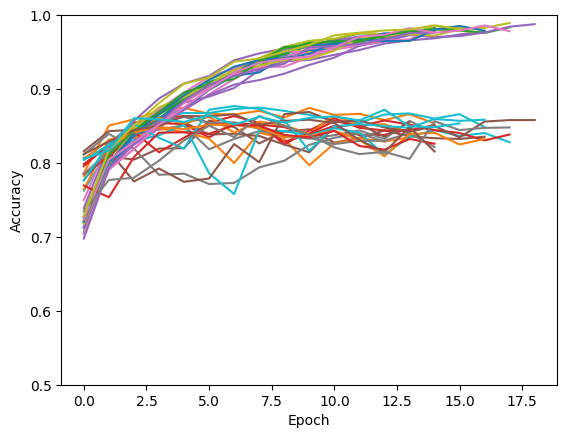

In [56]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(config['ensembleSize']):
    model = load_model(f'{MODEL_FILE}/{i}.keras')
    plt.plot(history_dict[i]['accuracy'], label=f'accuracy {i}')
    plt.plot(history_dict[i]['val_accuracy'], label = f'val_accuracy {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])

    test_loss, test_acc, test_auc = model.evaluate(test_images,  test_labels, verbose=2)

In [57]:
import pandas as pd

def produce_df_from_predictions(model_under_test, test_images, test_labels):
    outputs_stack = model_under_test.verbose_predict(test_images)
    outputs_mean = np.mean(outputs_stack, axis=0)
    outputs_variance = np.var(outputs_stack, axis=0)
    ensemble_predictions = np.where(outputs_mean > 0.5, 1, 0)
    individual_outputs = np.array(outputs_stack).squeeze().T.tolist()
    output_confidence = np.abs(outputs_mean - 0.5)
    prediction_outcome = np.where(ensemble_predictions != test_labels, 0, 1)
    np_df = np.hstack((output_confidence, outputs_variance, prediction_outcome, outputs_mean, test_labels, ensemble_predictions))
    df = pd.DataFrame(np_df, columns=['confidence', 'variance', 'outcome', 'mean', 'label', 'prediction'])
    df['individual_predictions'] = individual_outputs
    print(df.head())
    df['tp'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 1), axis=1)
    df['fp'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 1), axis=1)
    df['tn'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 0), axis=1)
    df['fn'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 0), axis=1)

    df.head()

    return df

df = produce_df_from_predictions(model_under_test, test_images, test_labels)

df_held_out = produce_df_from_predictions(model_under_test, test_images_held_out, test_labels_held_out)
print(df_held_out.head())


   confidence  variance  outcome      mean  label  prediction  \
0    0.077495  0.034414      0.0  0.577495    0.0         1.0   
1    0.406061  0.008198      1.0  0.093939    0.0         0.0   
2    0.417885  0.005181      1.0  0.082115    0.0         0.0   
3    0.195827  0.008125      1.0  0.695827    1.0         1.0   
4    0.386075  0.001943      1.0  0.886075    1.0         1.0   

                              individual_predictions  
0  [0.8568212389945984, 0.511316180229187, 0.7625...  
1  [0.06908851116895676, 0.03581205755472183, 0.2...  
2  [0.044671088457107544, 0.04271075129508972, 0....  
3  [0.8955329060554504, 0.7452958226203918, 0.707...  
4  [0.9596236944198608, 0.9185067415237427, 0.825...  
   confidence  variance  outcome      mean  label  prediction  \
0    0.381439  0.008735      1.0  0.118561    0.0         0.0   
1    0.199458  0.042906      1.0  0.300542    0.0         0.0   
2    0.445870  0.004437      1.0  0.054130    0.0         0.0   
3    0.383234  0.00

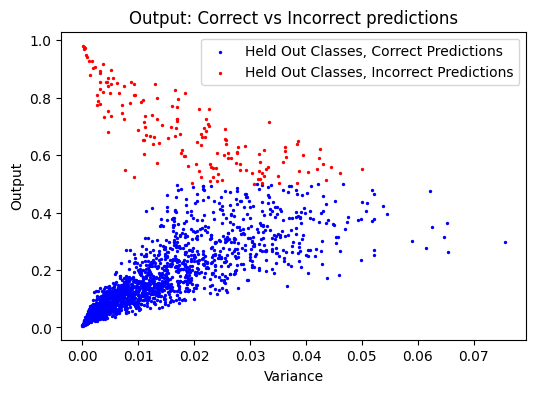

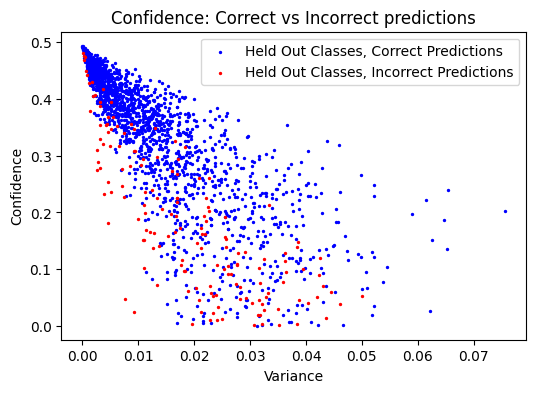

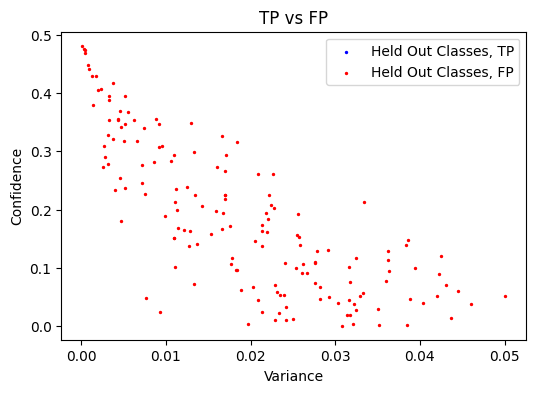

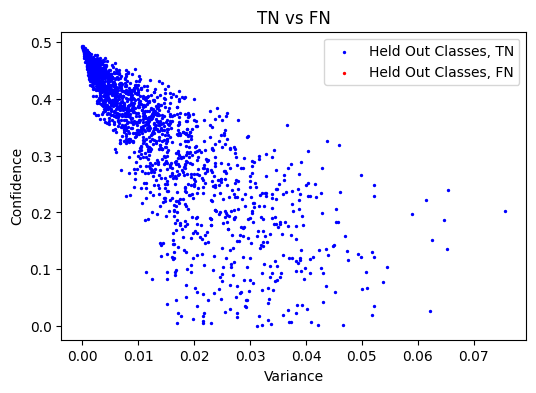

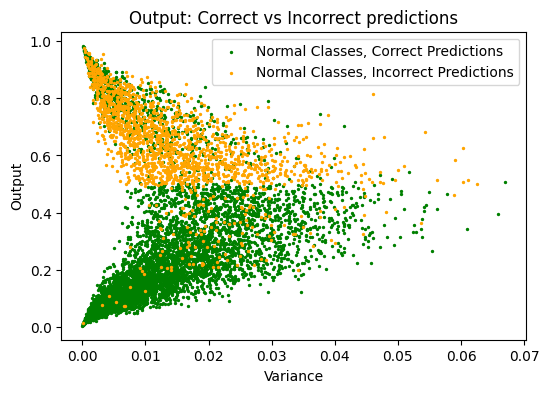

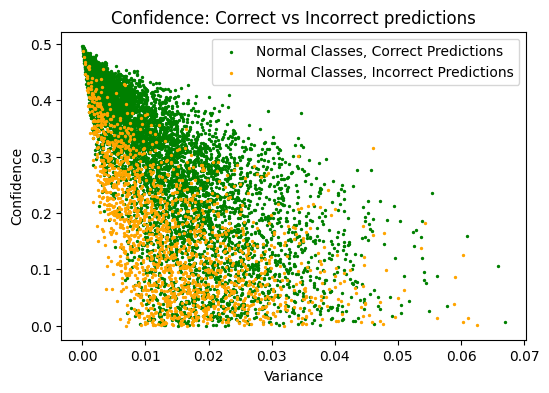

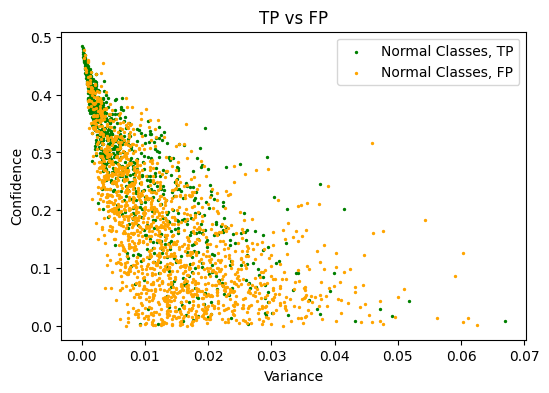

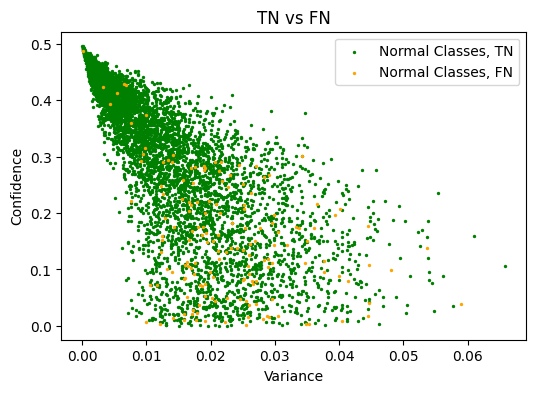

In [63]:

def normalize_and_plot(x, y, color, label=None):
    """Normalize and plot the given data."""
    # Convert to numpy for plotting

    # Normalize x and y
    # x_numpy_normalized = (x - x.min()) / (x.max() - x.min())
    # y_numpy_normalized = (y - y.min()) / (y.max() - y.min())

    # Plotting
    plt.scatter(x, y, color=color, label=label, s=2)

print()

def plot_confidence_vs_variance_findings(dataframes):
    for i, df in enumerate(dataframes):

        if i == 0:
            colour_correct = 'blue'
            colour_wrong = 'red'
        else:
            colour_correct = 'green'
            colour_wrong = 'orange'

        if i == 0:
            label = 'Normal Classes'
        else:
            label = 'Held Out Classes'

        var_correct = df[df['outcome'] == 1]['variance'].to_numpy()
        var_incorrect = df[df['outcome'] == 0]['variance'].to_numpy()
        output_correct = df[df['outcome'] == 1]['mean'].to_numpy()
        output_incorrect = df[df['outcome'] == 0]['mean'].to_numpy()
        conf_correct = df[df['outcome'] == 1]['confidence'].to_numpy()
        conf_incorrect = df[df['outcome'] == 0]['confidence'].to_numpy()
        var_tp = df[df['tp'] == 1]['variance'].to_numpy()
        conf_tp = df[df['tp'] == 1]['confidence'].to_numpy()
        var_fp = df[df['fp'] == 1]['variance'].to_numpy()
        conf_fp = df[df['fp'] == 1]['confidence'].to_numpy()
        var_tn = df[df['tn'] == 1]['variance'].to_numpy()
        conf_tn = df[df['tn'] == 1]['confidence'].to_numpy()
        var_fn = df[df['fn'] == 1]['variance'].to_numpy()
        conf_fn = df[df['fn'] == 1]['confidence'].to_numpy()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_correct, output_correct, colour_correct, f'{label}, Correct Predictions')
        normalize_and_plot(var_incorrect, output_incorrect, colour_wrong, f'{label}, Incorrect Predictions')
        # Add labels and legend
        plt.title(f'Output: Correct vs Incorrect predictions')
        plt.xlabel('Variance')
        plt.ylabel('Output')
        plt.legend()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_correct, conf_correct, colour_correct, f'{label}, Correct Predictions')
        normalize_and_plot(var_incorrect, conf_incorrect, colour_wrong, f'{label}, Incorrect Predictions')
        # Add labels and legend
        plt.title(f'Confidence: Correct vs Incorrect predictions')
        plt.xlabel('Variance')
        plt.ylabel('Confidence')
        plt.legend()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_tp, conf_tp, colour_correct, f'{label}, TP')
        normalize_and_plot(var_fp, conf_fp, colour_wrong, f'{label}, FP')
        plt.title(f'TP vs FP')
        plt.xlabel('Variance')
        plt.ylabel('Confidence')
        plt.legend()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_tn, conf_tn, colour_correct, f'{label}, TN')
        normalize_and_plot(var_fn, conf_fn, colour_wrong, f'{label}, FN')
        plt.title(f'TN vs FN')
        plt.xlabel(f'Variance')
        plt.ylabel(f'Confidence')
        plt.legend()

plot_confidence_vs_variance_findings([df_held_out, df])

# Display the plot
plt.show()

In [59]:
from sklearn.metrics import confusion_matrix

tp_count = df['tp'].sum()
tn_count = df['tn'].sum()
fp_count = df['fp'].sum()
fn_count = df['fn'].sum()


accuracy = ( tp_count + tn_count ) / ( tp_count + tn_count + fp_count + fn_count )

precision = tp_count / ( tp_count + fp_count )

recall = tp_count / ( tp_count + fn_count )

f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )

confusion = confusion_matrix(test_labels, df['prediction'])

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.785375
Precision: 0.3506872136609746
Recall: 0.842
F1 Score: 0.49514848573948844
Confusion Matrix:
[[5441 1559]
 [ 158  842]]


In [60]:

true_positive_indices = df[df['tp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_positive_indices = df[df['fp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
true_negative_indices = df[df['tn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_negative_indices = df[df['fn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()

most_confident_outputs = false_negative_indices[0:24]

print(most_confident_outputs)




[2904 5699 4486 3811 2964 7442 7722 3456  876 6644  371 7614 2436 5725
 7593 5746 5539 2292 5266 6487 1808  626 4428  827]


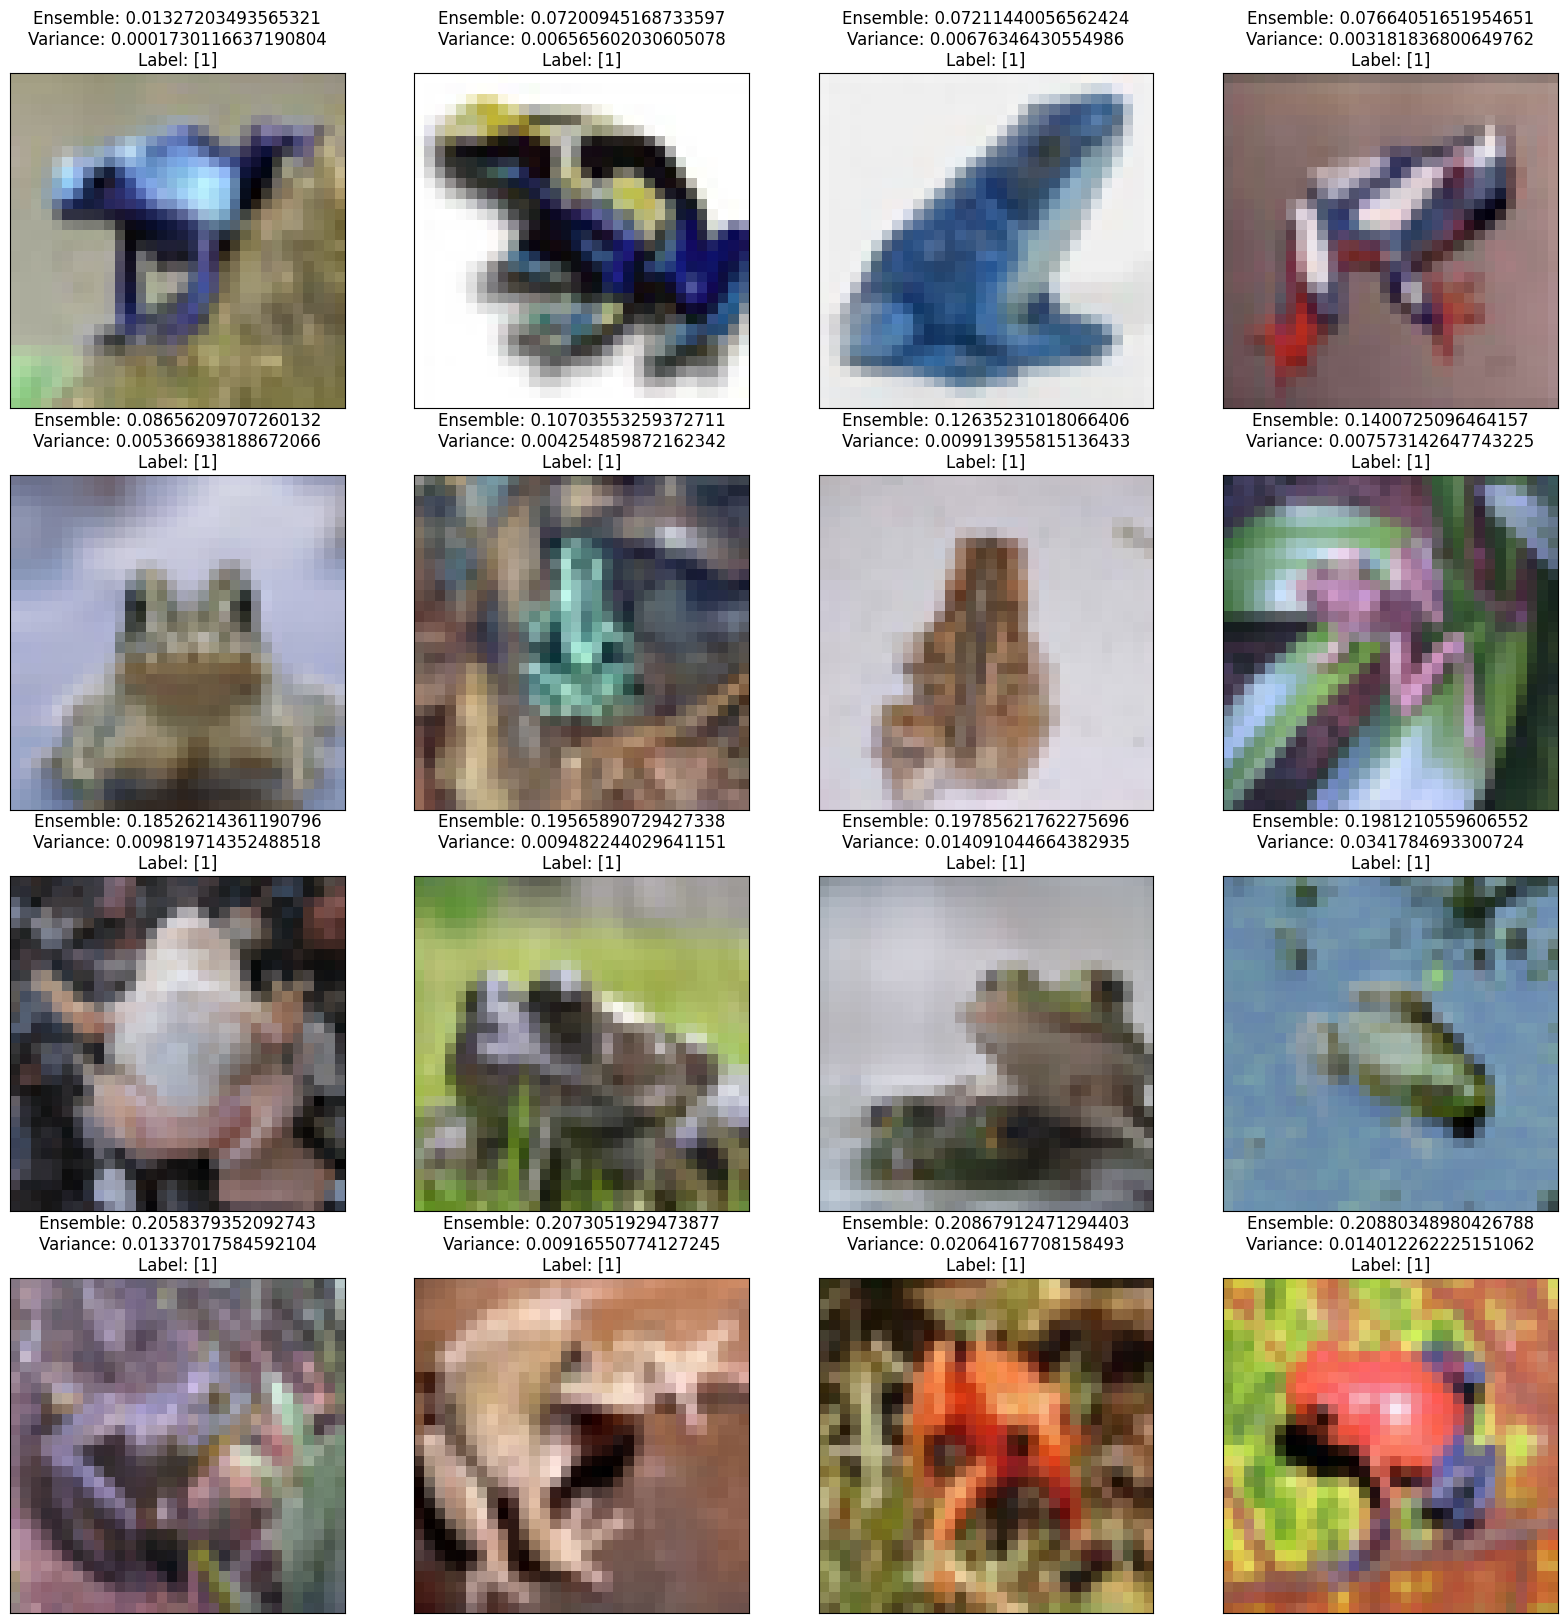

In [61]:



import matplotlib.pyplot as plt

# Create a 10x10 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    # Get the index of the current image
    index = most_confident_outputs[i]

    # Display the image
    ax.imshow(test_images[index], cmap='gray')

    # Get the predictions of the individual models and the ensemble
    # 2 x 10000 x 1
    individual_pred = df['individual_predictions'].iloc[index]
    ensemble_pred = df['mean'].iloc[index]
    ensemble_var = df['variance'].iloc[index]

    # Display the predictions
    ax.set_title(f'Ensemble: {ensemble_pred}\nVariance: {ensemble_var}\nLabel: {test_labels[index]}')

    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()

